<a href="https://colab.research.google.com/github/patrickanaku/MCS-7103-Machine-Learning/blob/main/Course_Work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Visualize missing data
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('HEATMAP VISUALIZATION OF COLUMNS/FEATURES WITH MISSING VALUES')
#plt.show()

# Missing indicators for key columns
acled_data['assoc_actor_1_missing'] = acled_data['assoc_actor_1'].isnull().astype(int)
acled_data['actor2_missing'] = acled_data['actor2'].isnull().astype(int)
acled_data['assoc_actor_2_missing'] = acled_data['assoc_actor_2'].isnull().astype(int)
acled_data['civilian_targeting_missing'] = acled_data['civilian_targeting'].isnull().astype(int)

# Mode imputation
acled_data['assoc_actor_1'] = acled_data['assoc_actor_1'].fillna(acled_data['assoc_actor_1'].mode()[0])
acled_data['actor2'].fillna(acled_data['actor2'].mode()[0], inplace=True)
acled_data['assoc_actor_2'].fillna(acled_data['assoc_actor_2'].mode()[0], inplace=True)
acled_data['civilian_targeting'].fillna(acled_data['civilian_targeting'].mode()[0], inplace=True)

# Visualize missing data after imputation
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('Missing Data Heatmap')
#plt.show()

# Drop unnecessary columns
columns_to_drop = ['event_id_cnty', 'year', 'source', 'notes']
acled_data.drop(columns=[col for col in columns_to_drop if col in acled_data.columns], inplace=True)

# Feature engineering
if 'event_date' in acled_data.columns:
    acled_data['event_date'] = pd.to_datetime(acled_data['event_date'])
    acled_data['day'] = acled_data['event_date'].dt.day
    acled_data['month'] = acled_data['event_date'].dt.month
    acled_data['year'] = acled_data['event_date'].dt.year
    acled_data['day_of_week'] = acled_data['event_date'].dt.dayofweek
    acled_data.drop(columns=['event_date'], inplace=True)

if 'disorder_type' in acled_data.columns and 'region' in acled_data.columns:
    acled_data['disorder_region'] = acled_data['disorder_type'] + "_" + acled_data['region']

acled_data['latitude_bin'] = pd.cut(acled_data['latitude'], bins=[-90, -30, 0, 30, 90], labels=['South', 'Tropical', 'Equator', 'North'])

# Define features and target
X = acled_data.drop(columns=['fatalities'])  # Features
y = acled_data['fatalities']  # Target variable

# Identify categorical and numerical columns
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'inter1',
                       'interaction', 'region', 'country', 'location', 'source_scale',
                       'day', 'month', 'year', 'day_of_week', 'disorder_region', 'latitude_bin']
numerical_columns = ['time_precision', 'iso', 'latitude', 'longitude', 'geo_precision', 'timestamp']

use clusters to group countries or regions

## **Exploratory Data Analysis of the ACLED Conflict Data for Africa 1997-2024**

The raw dataset was collected from ACLED website, this dataset is a collection reported information on the type, agents, location, date, and other characteristics of political violence events, demonstration events, and other select non-violent, politically relevant developments in every country and territory in the world. Below is a link to the dataset and explantion of the features in the dataset respectivily.

https://data.world/acled/71d852e4-e41e-4320-a770-9fc2bb87fb64

https://acleddata.com/acleddatanew/wp-content/uploads/dlm_uploads/2023/06/ACLED_Codebook_2023.pdf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
!pip install plotly
!pip install geopandas
!pip install alluvial
!pip install wordcloud
!pip install circlify

from wordcloud import WordCloud, STOPWORDS
import circlify

from tabulate import tabulate

In [ ]:
africadata = pd.read_csv('/content/drive/MyDrive/MCSC1/dataset/Africa_1997-2024_Oct11.csv')

# **A QUICK LOOK INTO THE DATASET**

Quick view at the features and datatypes

In [ ]:
africadata.shape

(389425, 31)

In [ ]:
africadata.info()

In [ ]:
africadata.head(5)

In [ ]:
africadata.tail(3)

# **EXPLORATORY DATA ANALYSIS**

In [ ]:
from tabulate import tabulate

# Calculate the number of null values in each column
null_counts = africadata.isnull().sum()

# Filter columns with null values and get their names
null_columns = null_counts[null_counts > 0].index.tolist()

# Filter columns without null values and get their names
non_null_columns = null_counts[null_counts == 0].index.tolist()

# Create DataFrame for columns with null values
null_data = pd.DataFrame({
    'Column': null_columns,
    'Null Count': [africadata[col].isnull().sum() for col in null_columns]
})

# Print the number of columns without null values
print(f"\nNumber of columns without null values: {len(non_null_columns)}")

# Print the number of columns with null values
print(f"Number of columns with null values: {len(null_columns)}")

# Print null values table in a nice format
print(tabulate(null_data, headers='keys', tablefmt='grid'))

First we extracted and display the two types of features i.e numerical and categorical

In [ ]:
# Select and extract numerical features
numerical_features = africadata.select_dtypes(include=['int64', 'float64'])

# Print the first 5 rows of the numerical features in a pretty table
print(tabulate(numerical_features.head(15), headers='keys', tablefmt='pretty'))

In [ ]:
# Select and extract categorical features
categorical_features = africadata.select_dtypes(include=['object'])

# Display  features
# print("\nCategorical Features:")
print(tabulate(categorical_features.head(15), headers='keys', tablefmt='pretty'))

# Visualizing Categorical Variables

A bar chart to visualize event types by country

In [ ]:
# Stacked Bar Chart of Event Types by Country (Matplotlib)
# (Requires data manipulation to get counts of event types per country)
# Example (replace 'COUNTRY' with your actual country column):
event_counts = africadata.groupby(['country', 'event_type'])['event_id_cnty'].count().unstack()
event_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Stacked Bar Chart of Event Types by Country')
plt.xlabel('Country')
plt.ylabel('Number of Events')

A bar chart to visualize the frequency of event types

need to also plot event sub type

# Frequency of Event Subtypes (1997 - 2024)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))  # Adjust figure size as needed

# Get the value counts and sort them in descending order
# Removed extra spaces from column name 'SUB_EVENT_TYPE'
event_subtype_counts = africadata['sub_event_type'].value_counts()

# Create the bar chart
event_subtype_counts.plot(kind='bar', color='skyblue')

plt.title('Frequency of Event Subtypes (1997 - 2024)')
plt.xlabel('Event Subtype')
plt.ylabel('Count')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

A pie chart to visualize event types by their percentage value.

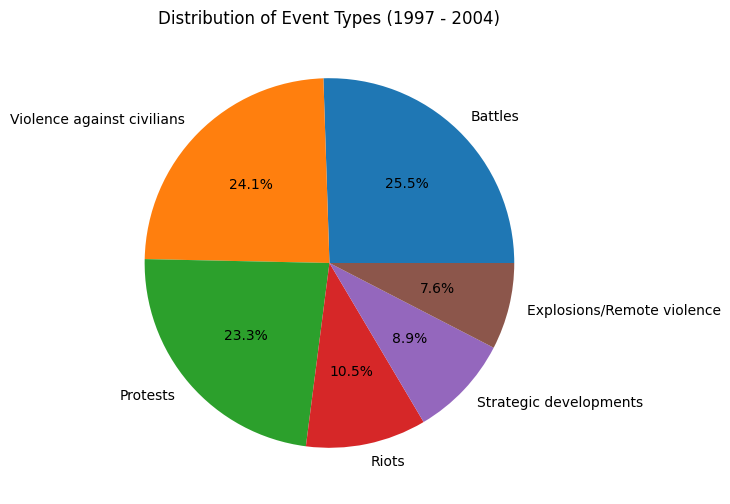

In [ ]:
plt.figure(figsize=(10, 6))
africadata['event_type'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Event Types (1997 - 2004)')
plt.ylabel('')
plt.show()

# Visualizing Numerical Variables

A box and whisker plot for each numerical features.

In [ ]:
africadata.boxplot(figsize=(30, 15))
plt.show()

A bar chart of total fatalities by year

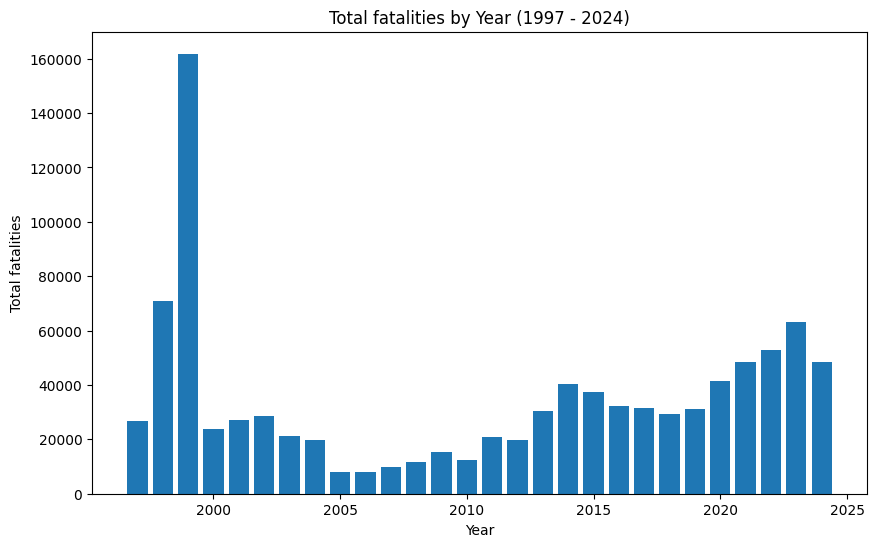

In [ ]:
# Convert 'EVENT_DATE' to datetime
africadata['event_date'] = pd.to_datetime(africadata['event_date'], format='mixed')

# Extract year from 'EVENT_DATE'
africadata['event_year'] = africadata['event_date'].dt.year

# Group data by year and sum fatalities
fatalities_by_year = africadata.groupby('event_year')['fatalities'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(fatalities_by_year['event_year'], fatalities_by_year['fatalities'])
plt.xlabel('Year')
plt.ylabel('Total fatalities')
plt.title('Total fatalities by Year (1997 - 2024)')
plt.show()

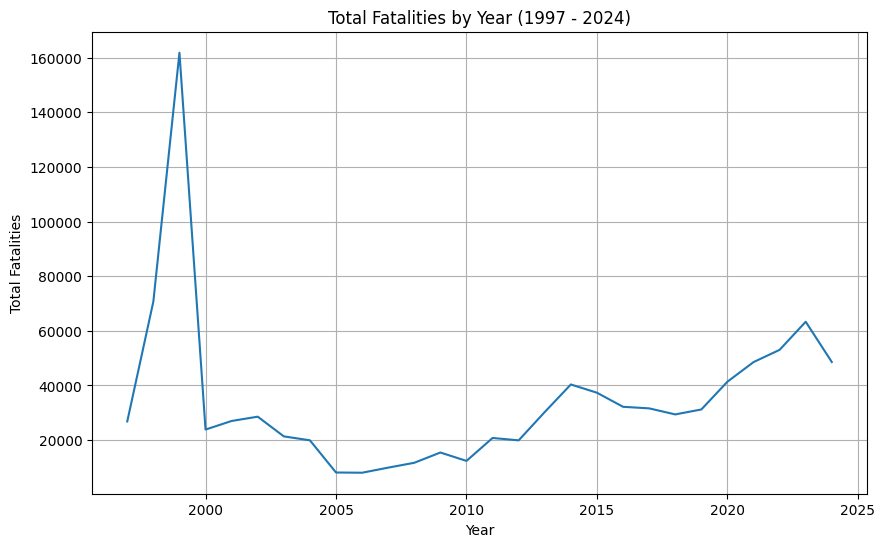

In [ ]:
# Assuming you have already converted 'EVENT_DATE' to datetime and extracted 'EVENT_YEAR'

# Group data by year and sum fatalities
fatalities_by_year = africadata.groupby('event_year')['fatalities'].sum().reset_index()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(fatalities_by_year['event_year'], fatalities_by_year['fatalities'])
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.title('Total Fatalities by Year (1997 - 2024)')
plt.grid(True)  # Add a grid for better readability
plt.show()

In [ ]:
africadata['actor1'].unique()

array(['Military Forces of Mali (2021-)',
       'Military Forces of Burkina Faso (2022-)',
       'JNIM: Group for Support of Islam and Muslims', ...,
       'Ekori Ethnic Militia (Nigeria)',
       'Police Forces of Algeria (1994-1999)', 'BAT: Boere Attack Troop'],
      dtype=object)

In [ ]:
africadata['actor2'].unique()

array(['Civilians (Niger)',
       'JNIM: Group for Support of Islam and Muslims',
       'Military Forces of Burkina Faso (2022-)', ...,
       'Police Forces of Algeria (1994-1999)',
       'Ekori Ethnic Militia (Nigeria)',
       'UFDF: Uganda Federal Democratic Front'], dtype=object)

In [ ]:
africadata['assoc_actor_1'].unique()

array([nan, 'Students (Burkina Faso)',
       'Vigilante Group (Democratic Republic of Congo)', ...,
       'San Ethnic Group (Namibia)',
       'Military Forces of Ethiopia (1991-2018); NDA: National Democratic Alliance (Sudan)',
       'Military Forces of the Central African Republic (1993-2003) Yakoma Faction'],
      dtype=object)

In [ ]:
africadata['assoc_actor_2'].unique()

array(['Miners (Niger)', nan, 'VDP: Volunteer for Defense of Homeland',
       ...,
       'Aid Workers (Spain); Women (Spain); Aid Workers (United States)',
       'NADECO: National Democratic Coalition Militia',
       'Government of the United States (1993-2001)'], dtype=object)

In [ ]:
africadata['country'].unique()

array(['Mali', 'Burkina Faso', 'Djibouti', 'Democratic Republic of Congo',
       'Ethiopia', 'Ghana', 'Kenya', 'Libya', 'Malawi', 'Morocco',
       'Nigeria', 'South Africa', 'Somalia', 'Sudan', 'Tunisia', 'Uganda',
       'Benin', 'Central African Republic', 'Guinea', 'Madagascar',
       'Mauritius', 'Senegal', 'South Sudan', 'Reunion', 'Ivory Coast',
       'Guinea-Bissau', 'Mauritania', 'Mozambique', 'Niger', 'eSwatini',
       'Togo', 'Algeria', 'Cameroon', 'Mayotte', 'Egypt', 'Liberia',
       'Namibia', 'Zimbabwe', 'Gabon', 'Burundi', 'Chad', 'Tanzania',
       'Angola', 'Cape Verde', 'Comoros', 'Lesotho', 'Botswana', 'Rwanda',
       'Zambia', 'Eritrea', 'Seychelles', 'Sao Tome and Principe',
       'Gambia', 'Sierra Leone', 'Republic of Congo', 'Equatorial Guinea',
       'Saint Helena, Ascension and Tristan da Cunha'], dtype=object)

# Visualizing fatalities by actor type

Line chart of fatality by event actors (1997 - 2024)

In [ ]:
# Group data by actor type and year, then sum fatalities
fatalities_over_time = africadata.groupby(['year', 'actor1'])['fatalities'].sum().reset_index()

# Limit the number of actors to the top 10 for plotting
top_actors = fatalities_over_time.groupby('actor1')['fatalities'].sum().nlargest(10).index
fatalities_over_time_top10 = fatalities_over_time[fatalities_over_time['actor1'].isin(top_actors)]

# Create the line plot using seaborn
plt.figure(figsize=(12, 8))
sns.lineplot(x='year', y='fatalities', hue='actor1', data=fatalities_over_time_top10)
plt.title('Total Fatalities by Actor Type Over Time (Top 10 Actors)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Fatalities', fontsize=14)

# Adjust legend for better readability
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), ncol=1, fontsize=12)

# Add grid for better visualization
plt.grid(True)
plt.tight_layout()

plt.show()

Bar chart of fatality by event actors (1997 - 2024)

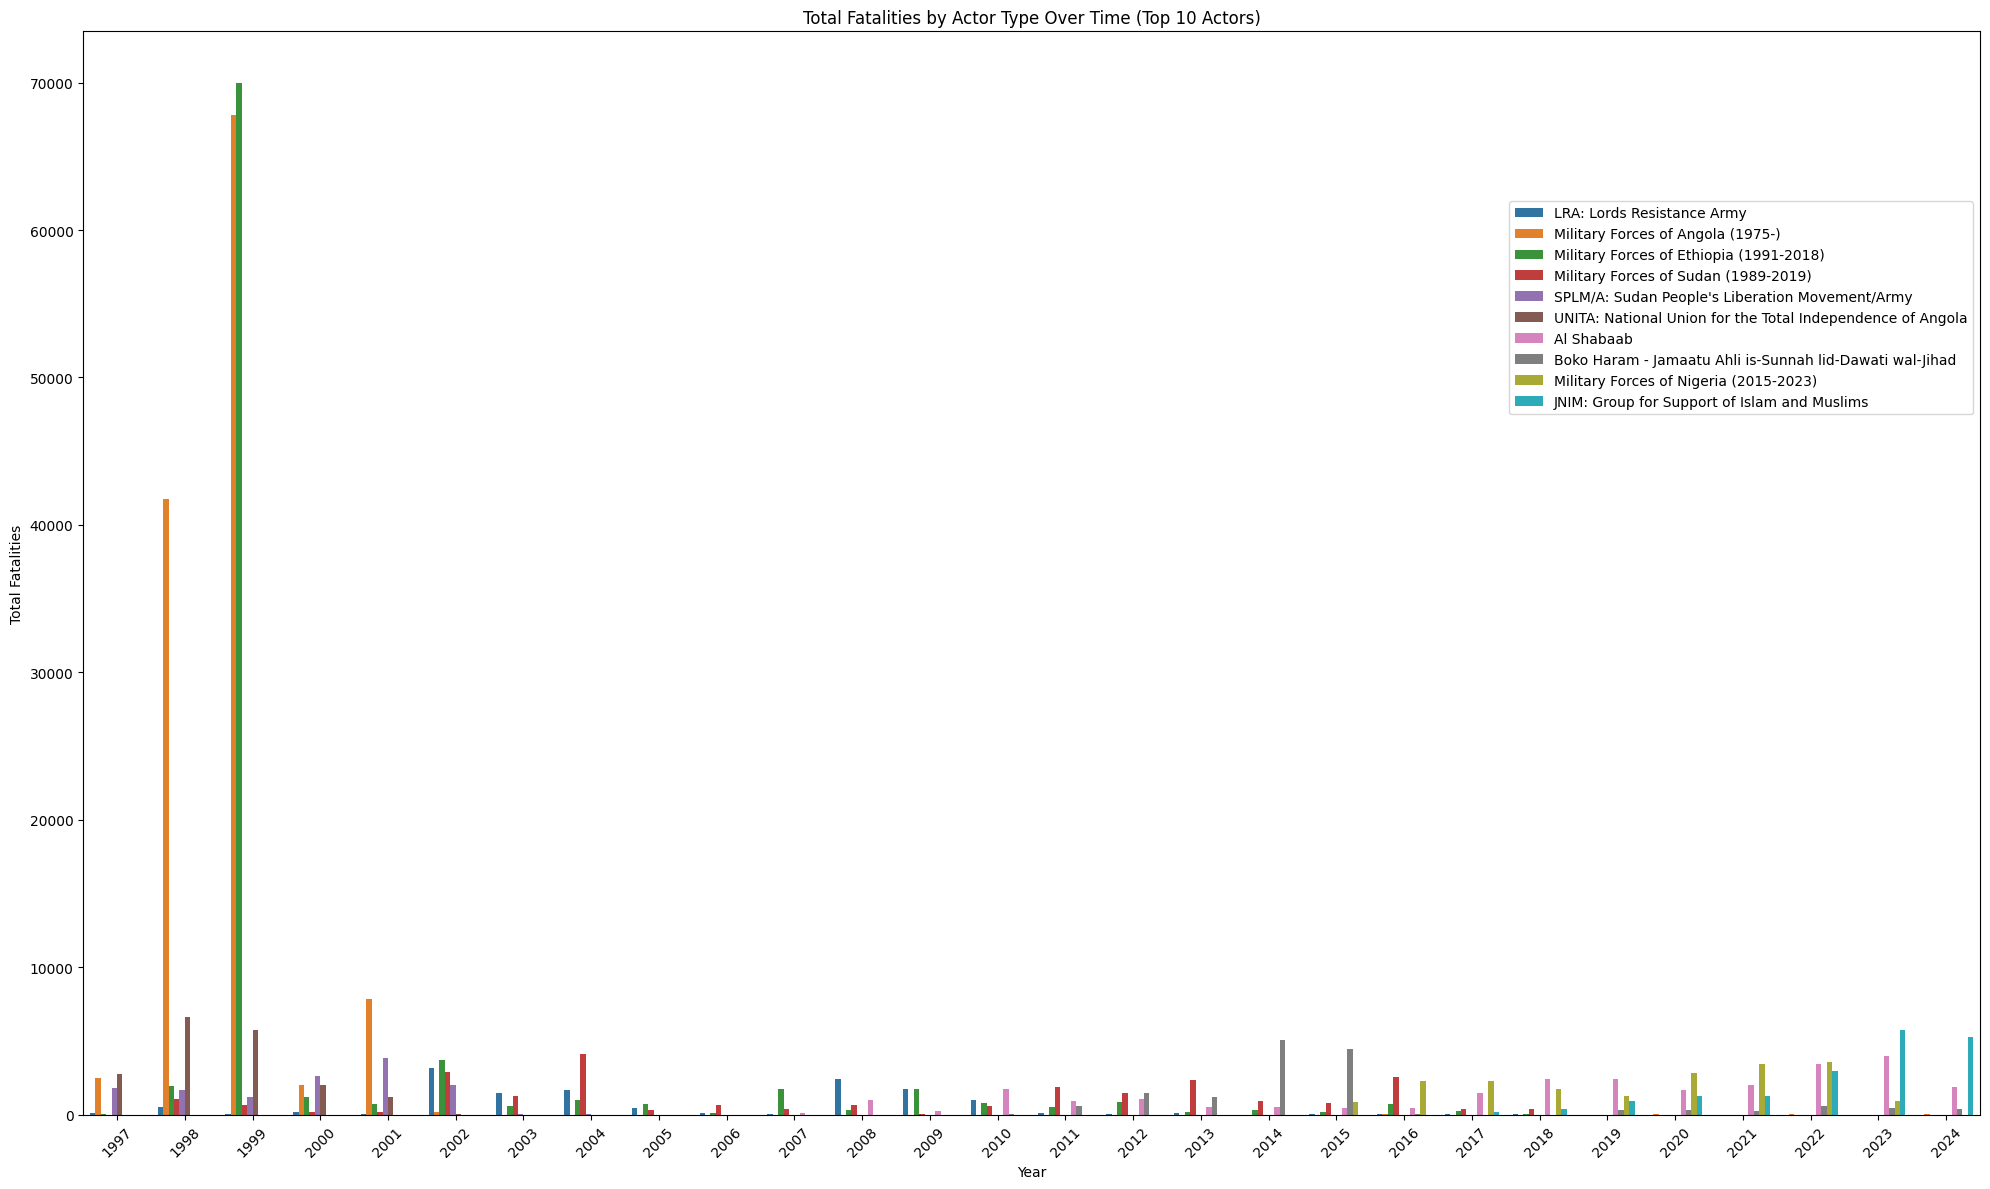

In [ ]:
# Group data by actor type and year, then sum fatalities
fatalities_over_time = africadata.groupby(['year', 'actor1'])['fatalities'].sum().reset_index()

# Limit the number of actors to the top 10 for plotting
top_actors = fatalities_over_time.groupby('actor1')['fatalities'].sum().nlargest(10).index
fatalities_over_time_top10 = fatalities_over_time[fatalities_over_time['actor1'].isin(top_actors)]

# Create the bar plot using seaborn
plt.figure(figsize=(20, 12))
sns.barplot(x='year', y='fatalities', hue='actor1', data=fatalities_over_time_top10)
plt.title('Total Fatalities by Actor Type Over Time (Top 10 Actors)')
plt.xticks(rotation=45)
plt.xlabel('Year')
plt.ylabel('Total Fatalities')
plt.tight_layout()

# Adjust legend position for better readability
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.85), ncol=1)

plt.show()

visualization of fatalities by event type using a bar char

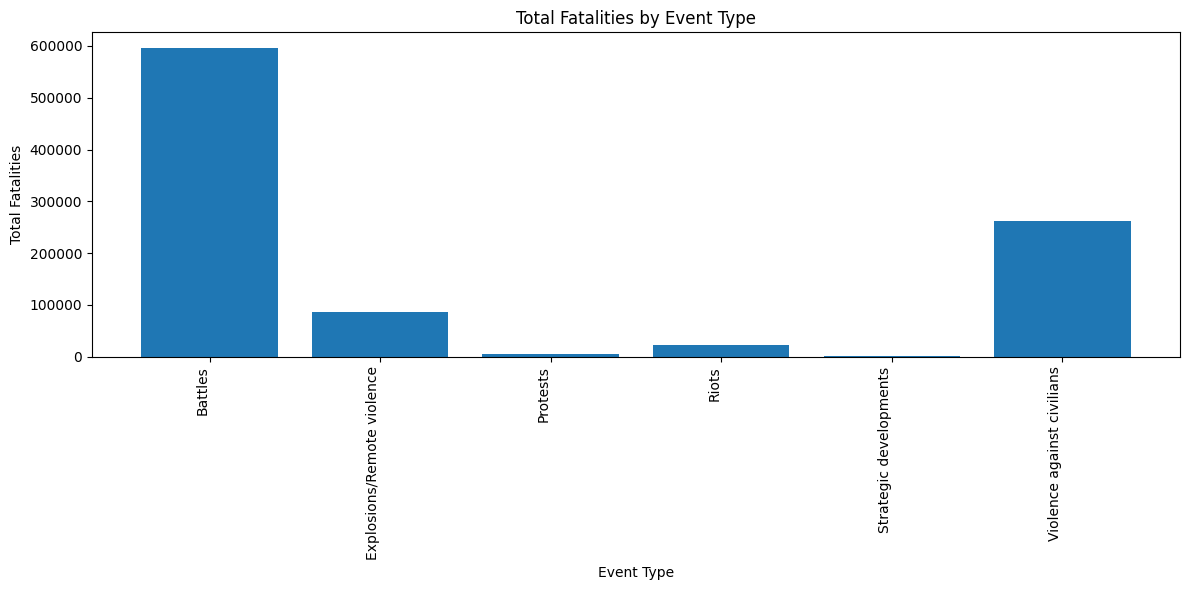

In [ ]:
# Group data by event type and sum fatalities
fatalities_by_event_type = africadata.groupby('event_type')['fatalities'].sum().reset_index()

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.bar(fatalities_by_event_type['event_type'], fatalities_by_event_type['fatalities'])
plt.xlabel('Event Type')
plt.ylabel('Total Fatalities')
plt.title('Total Fatalities by Event Type')
plt.xticks(rotation=90, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

# **Temporal Analysis**

Visualizing total events over time

In [ ]:
# Convert 'EVENT_DATE' to datetime
africadata['event_date'] = pd.to_datetime(africadata['event_date'], format='mixed')

# Extract year from 'EVENT_DATE'
africadata['year'] = africadata['event_date'].dt.year

# Group data by year and count events
events_by_year = africadata.groupby('year')['event_type'].count()

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(events_by_year.index, events_by_year.values)
plt.xlabel('Year')
plt.ylabel('Number of Events')
plt.title('Trend of Events Over Time')
plt.show()

Visualizing total events over time by country

In [ ]:
import plotly.express as px

#Convert 'EVENT_DATE' to datetime. Use infer_datetime_format to handle multiple date formats
africadata['event_date'] = pd.to_datetime(africadata['event_date'], format='mixed')

# Time Series of Events Over Time (with Plotly)
events_over_time = africadata.groupby('event_date')['country'].count().reset_index()

fig = px.line(events_over_time, x='event_date', y='country', title='Number of Events Over Time') # Also update here
fig.show()

Number of Events over time by event type

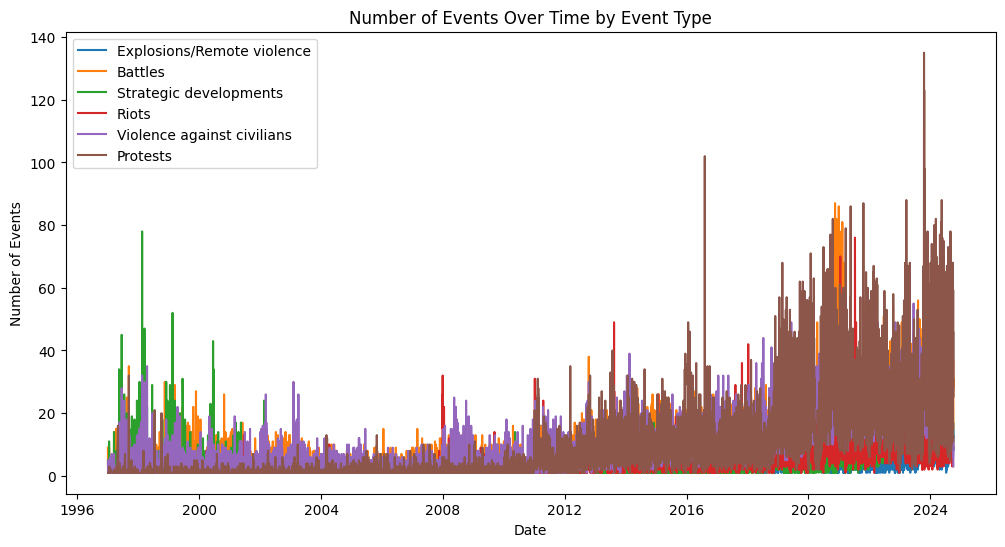

In [ ]:
# Time Series with Event Type Segmentation (Matplotlib)
plt.figure(figsize=(12, 6))
for event_type in africadata['event_type'].unique():
  df_temp = africadata[africadata['event_type'] == event_type].groupby('event_date')['event_id_cnty'].count()
  plt.plot(df_temp, label=event_type)
plt.title('Number of Events Over Time by Event Type')
plt.xlabel('Date')
plt.ylabel('Number of Events')
plt.legend()
# plt.grid(True)
plt.show()

# **Word Clouds**
  
The functionality of Pandas has helped me to highlight the most frequent words used in event descriptions of conflicts. Here I have created a word cloud from the 'DESCRPITION column to see the dominant words associated with specific event types or time periods.

In [ ]:
text = ' '.join(africadata['notes'].astype(str).tolist())
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stopwords).generate(text)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Relationship between actors

# DATA PRE-PROCESSING AND FEATURE ENGINEERING

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install category_encoders
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from category_encoders import TargetEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Load the dataset
acled_data = pd.read_csv('/content/drive/MyDrive/MCSC1/dataset/Africa_1997-2024_Oct11.csv')

In [ ]:
acled_data.info()

In [5]:
missing_percentage = (acled_data.isnull().sum() / len(acled_data)) * 100
columns_above_threshold = missing_percentage[missing_percentage > 50].index.tolist()
print("Columns with more than 50% missing values:", columns_above_threshold)

Columns with more than 50% missing values: ['assoc_actor_1', 'assoc_actor_2', 'civilian_targeting', 'tags']


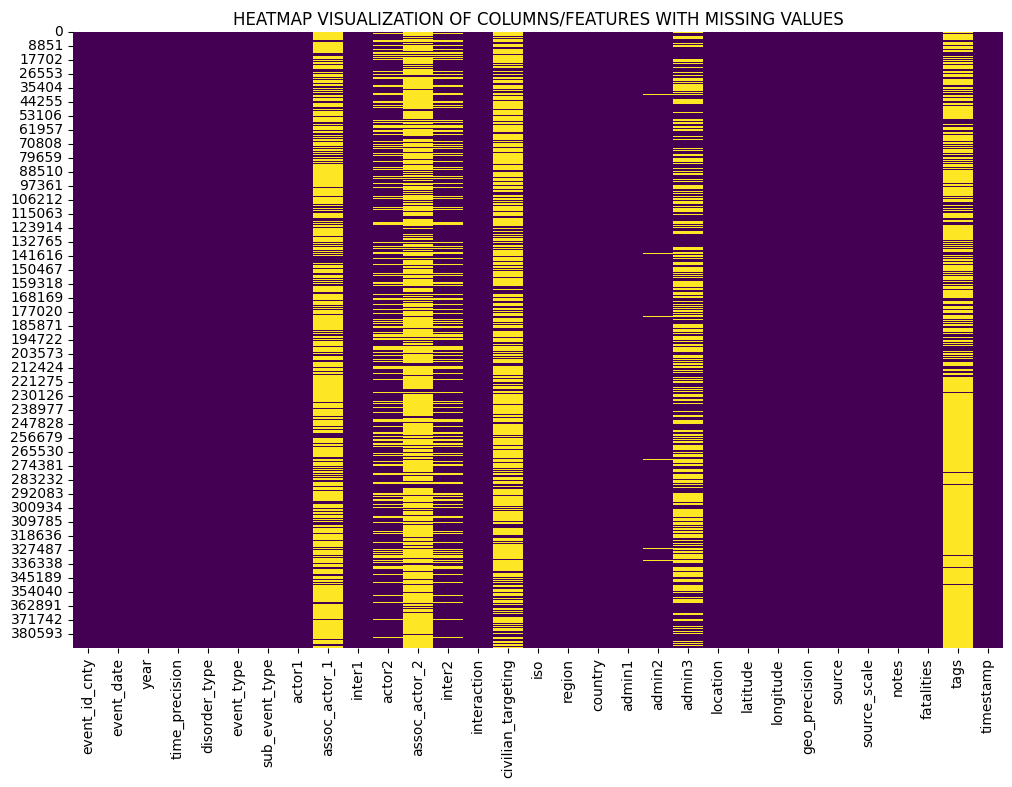

In [6]:
# Visualizing missing data
plt.figure(figsize=(12, 8))
sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
plt.title('HEATMAP VISUALIZATION OF COLUMNS/FEATURES WITH MISSING VALUES')
plt.show()


Imputing Missing values for Categorical Variables



1. Missing Indicator: I first Created an indicator column to signify presense of missing values.

2. Mode Imputation: I have used the most common value to fill missing entries.

3. Impacted features are: assoc_actor_1, actor2, assoc_actor_2, and civilian_targeting:

In [7]:
# missing indicators
acled_data['admin2_missing'] = acled_data['admin2'].isnull().astype(int)

# Mode imputation
acled_data.loc[:, 'admin2'] = acled_data['admin2'].fillna(acled_data['admin2'].mode()[0])


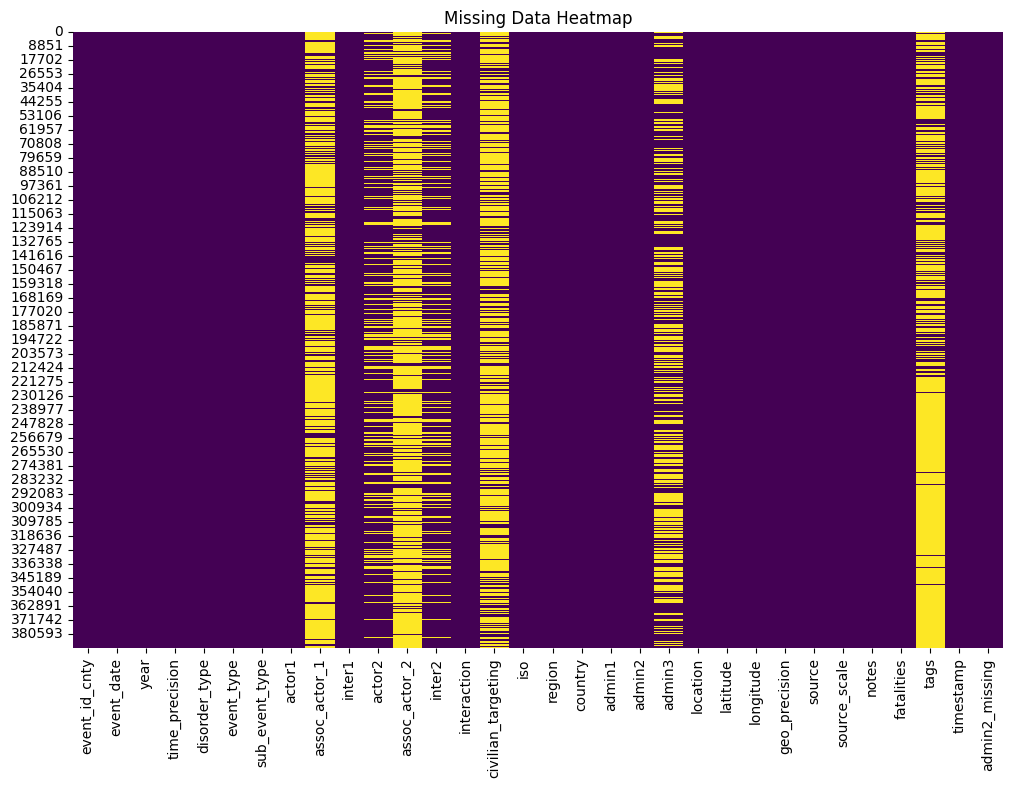

In [8]:
# Visualization of missing data after imputation
plt.figure(figsize=(12, 8))
sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

# **BUILDING THE MODELS**



# **LINEAR REGRESSION**

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

Drop unnecessary columns

In [10]:
columns_to_drop = ['event_id_cnty', 'year', 'source', 'notes','iso', 'tags', 'admin3',
                   'inter2','assoc_actor_1', 'assoc_actor_2', 'civilian_targeting', 'tags', 'actor2']
acled_data.drop(columns=[col for col in columns_to_drop
                          if col in acled_data.columns], inplace=True)

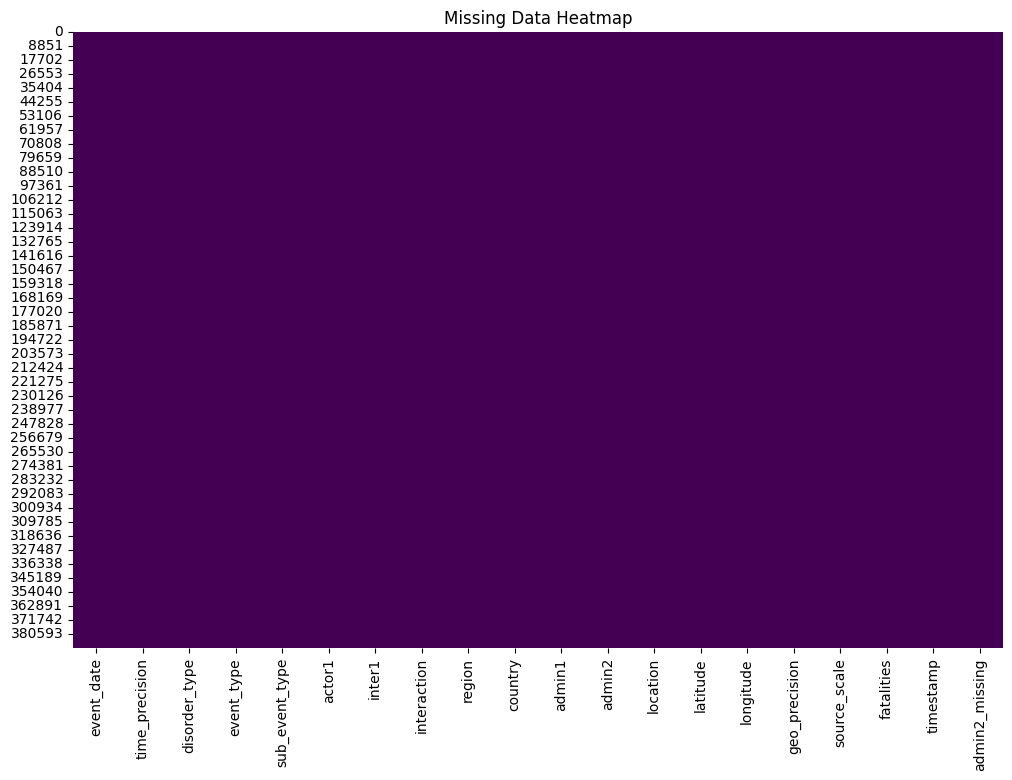

In [11]:
# Visualization of missing data after imputation
plt.figure(figsize=(12, 8))
sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

Feature Engineering

In [13]:
# 1. Extract Date Features (Assuming event_date is available)
if 'event_date' in acled_data.columns:
    acled_data['event_date'] = pd.to_datetime(acled_data['event_date'])
    acled_data['day'] = acled_data['event_date'].dt.day
    acled_data['month'] = acled_data['event_date'].dt.month
    acled_data['year'] = acled_data['event_date'].dt.year
    acled_data['day_of_week'] = acled_data['event_date'].dt.dayofweek
    # Drop 'event_date' after extracting features
    acled_data.drop(columns=['event_date'], inplace=True) # Drop event_date after feature extraction

# 2. Create Interaction Terms
if 'disorder_type' in acled_data.columns and 'region' in acled_data.columns:
    acled_data['disorder_region'] = acled_data['disorder_type'] + "_" + acled_data['region']

# 3. Binning Numerical Variables (Example for latitude)
acled_data['latitude_bin'] = pd.cut(acled_data['latitude'], bins=[-90, -30, 0,
                    30, 90], labels=['South', 'Tropical', 'Equator', 'North'])

Define features and target variable

In [14]:
X = acled_data.drop(columns=['fatalities'])  # Features
y = acled_data['fatalities']  # Target variable

# Identify categorical and numerical columns
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1',
                       'inter1', 'interaction', 'region', 'country', 'location', 'source_scale',
                       'day', 'month', 'year', 'day_of_week', 'disorder_region', 'latitude_bin']
numerical_columns = ['time_precision', 'latitude', 'longitude', 'geo_precision', 'timestamp']

# Create a ColumnTransformer to apply OneHotEncoder to categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)  # OneHotEncode categorical features
    ])


Pipeline that preprocesses the data, then fits the model

In [15]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', LinearRegression())])  # Regression model

Split the data into training and testing sets

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Fit the model

In [17]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_precision', 'latitude',
                                                   'longitude', 'geo_precision',
                                                   'timestamp']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['disorder_type',
                                                   'event_type',
                                                   'sub_event_type', 'actor1',
                                                   'inter1', 'interaction',
                                                   'region', 'country',
                                                   'location', 'source_scale',
                                                   'day', 'month', 'year',
                                                   'day_of_week',
                                                   'disorder_region',
                                                   'latitude_bin'])])),
                ('regressor', LinearRegression())])

Make predictions

In [18]:
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Model Evaluation

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tabulate import tabulate

# Assuming you have your Linear Regression model predictions in 'y_pred_linear' and actual values in 'y_test'

# Calculate the metrics
mse_linear = mean_squared_error(y_test, y_pred)
rmse_linear = np.sqrt(mse_linear)
mae_linear = mean_absolute_error(y_test, y_pred)
r2_linear = r2_score(y_test, y_pred)

# Create the table data
table_data = [
    ["Metric", "Value"],
    ["MSE", mse_linear],
    ["RMSE", rmse_linear],
    ["MAE", mae_linear],
    ["R-squared", r2_linear],
]

# Print the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤════════════╕
│ Metric    │      Value │
╞═══════════╪════════════╡
│ MSE       │ 360.208    │
├───────────┼────────────┤
│ RMSE      │  18.9791   │
├───────────┼────────────┤
│ MAE       │   3.85362  │
├───────────┼────────────┤
│ R-squared │   0.440174 │
╘═══════════╧════════════╛


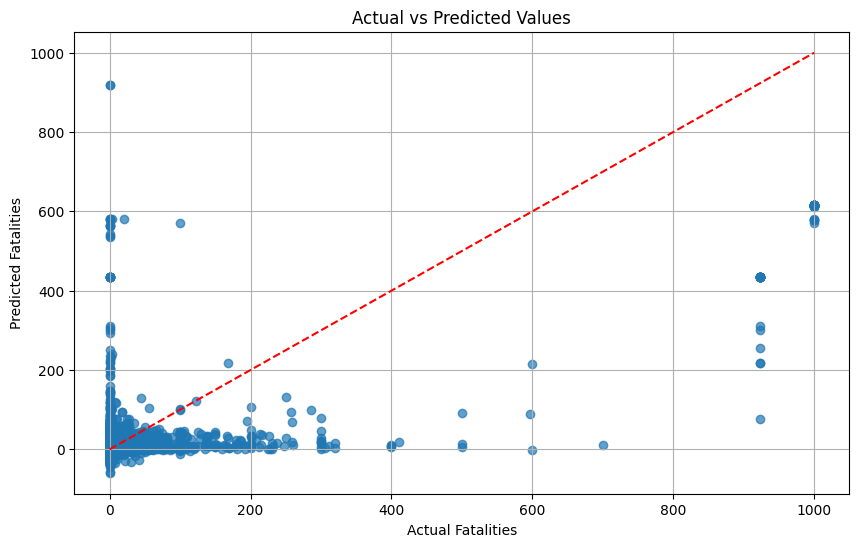

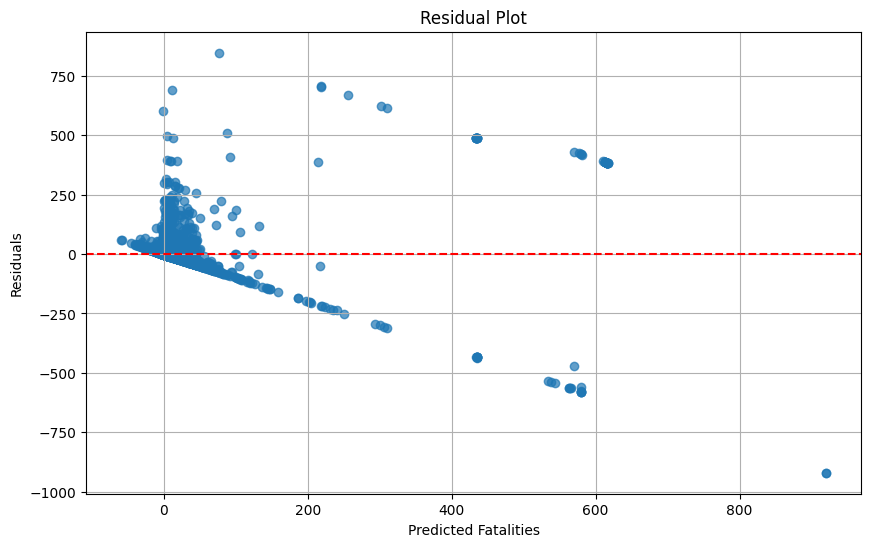

In [20]:

# 1. Scatter Plot of Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 45-degree line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.grid(True)
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Line at 0
plt.title('Residual Plot')
plt.xlabel('Predicted Fatalities')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()



# **LASSO** **REGRESSION**

In [21]:
from google.colab import drive
drive.mount('/content/drive')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tabulate import tabulate

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# Load the dataset
acled_data = pd.read_csv('/content/drive/MyDrive/MCSC1/dataset/Africa_1997-2024_Oct11.csv')

In [23]:
# Visualize missing data
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('HEATMAP VISUALIZATION OF COLUMNS/FEATURES WITH MISSING VALUES')
#plt.show()

# Missing indicators
acled_data['assoc_actor_1_missing'] = acled_data['assoc_actor_1'].isnull().astype(int)
acled_data['actor2_missing'] = acled_data['actor2'].isnull().astype(int)
acled_data['assoc_actor_2_missing'] = acled_data['assoc_actor_2'].isnull().astype(int)
acled_data['civilian_targeting_missing'] = acled_data['civilian_targeting'].isnull().astype(int)

# Mode imputation
acled_data['assoc_actor_1'].fillna(acled_data['assoc_actor_1'].mode()[0], inplace=True)
acled_data['actor2'].fillna(acled_data['actor2'].mode()[0], inplace=True)
acled_data['assoc_actor_2'].fillna(acled_data['assoc_actor_2'].mode()[0], inplace=True)
acled_data['civilian_targeting'].fillna(acled_data['civilian_targeting'].mode()[0], inplace=True)

# Visualize missing data after imputation
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('Missing Data Heatmap')
#plt.show()

# Drop unwanted columns
columns_to_drop = ['event_id_cnty', 'year', 'source', 'notes']
acled_data.drop(columns=[col for col in columns_to_drop if col in acled_data.columns], inplace=True)

# Extract date features
if 'event_date' in acled_data.columns:
    acled_data['event_date'] = pd.to_datetime(acled_data['event_date'])
    acled_data['day'] = acled_data['event_date'].dt.day
    acled_data['month'] = acled_data['event_date'].dt.month
    acled_data['year'] = acled_data['event_date'].dt.year
    acled_data['day_of_week'] = acled_data['event_date'].dt.dayofweek
    acled_data.drop(columns=['event_date'], inplace=True)

<ipython-input-23-cf5c4ff2584c>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  acled_data['assoc_actor_1'].fillna(acled_data['assoc_actor_1'].mode()[0], inplace=True)
<ipython-input-23-cf5c4ff2584c>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

In [24]:
# Create interaction terms
if 'disorder_type' in acled_data.columns and 'region' in acled_data.columns:
    acled_data['disorder_region'] = acled_data['disorder_type'] + "_" + acled_data['region']

# Binning numerical variables (example for latitude)
acled_data['latitude_bin'] = pd.cut(acled_data['latitude'], bins=[-90, -30, 0, 30, 90], labels=['South', 'Tropical', 'Equator', 'North'])

# Define features (X) and target (y)
X = acled_data.drop(columns=['fatalities'])  # Features
y = acled_data['fatalities']  # Target variable

# Identify categorical and numerical columns
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'inter1', 'interaction',
                       'region', 'country', 'location', 'source_scale', 'day', 'month', 'year',
                       'day_of_week', 'disorder_region', 'latitude_bin']
numerical_columns = ['time_precision', 'iso', 'latitude', 'longitude', 'geo_precision', 'timestamp']

In [25]:
# Create ColumnTransformer to apply OneHotEncoder to categorical features and scale numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)  # OneHotEncode categorical features
    ])

In [26]:
# Set up a Pipeline with Lasso Regression
model = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Preprocessing step
    ('regressor', Lasso(alpha=1.0))  # Lasso model with regularization parameter alpha
])

In [27]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_precision', 'iso',
                                                   'latitude', 'longitude',
                                                   'geo_precision',
                                                   'timestamp']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['disorder_type',
                                                   'event_type',
                                                   'sub_event_type', 'actor1',
                                                   'inter1', 'interaction',
                                                   'region', 'country',
                                                   'location', 'source_scale',
                                                   'day', 'month', 'year',
                                                   'day_of_week',
                                                   'disorder_region',
                                                   'latitude_bin'])])),
                ('regressor', Lasso())])

In [29]:
# Make predictions
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [30]:
# Calculate the evaluation metrics
mse_lasso = mean_squared_error(y_test, y_pred)
rmse_lasso = np.sqrt(mse_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred)
r2_lasso = r2_score(y_test, y_pred)

# Display the metrics
table_data = [
    ["Metric", "Value"],
    ["MSE", mse_lasso],
    ["RMSE", rmse_lasso],
    ["MAE", mae_lasso],
    ["R-squared", r2_lasso],
]

print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤══════════════╕
│ Metric    │        Value │
╞═══════════╪══════════════╡
│ MSE       │ 643.428      │
├───────────┼──────────────┤
│ RMSE      │  25.3659     │
├───────────┼──────────────┤
│ MAE       │   3.86662    │
├───────────┼──────────────┤
│ R-squared │  -4.1846e-07 │
╘═══════════╧══════════════╛


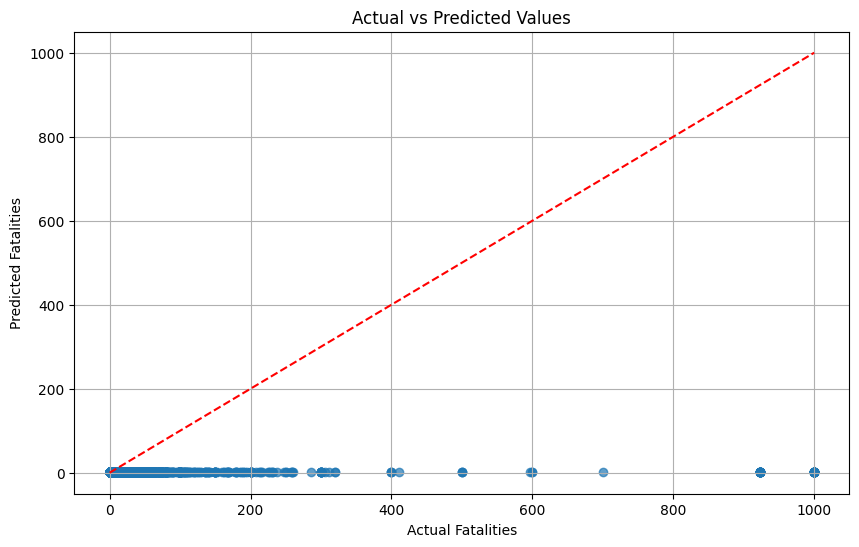

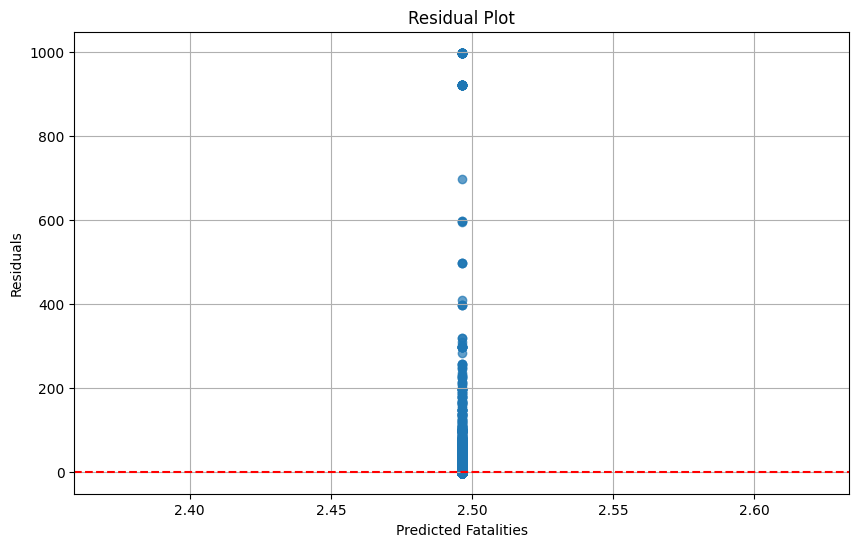

In [31]:


# Visualization

# 1. Scatter Plot of Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')  # 45-degree line
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.grid(True)
plt.show()

# 2. Residual Plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')  # Line at 0
plt.title('Residual Plot')
plt.xlabel('Predicted Fatalities')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# **RANDOM FOREST**

In [39]:
# Mount Google Drive and import libraries
from google.colab import drive
drive.mount('/content/drive')

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from tabulate import tabulate

# Load the dataset
acled_data = pd.read_csv('/content/drive/MyDrive/MCSC1/dataset/Africa_1997-2024_Oct11.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
acled_data.info()

In [40]:
# Visualize missing data
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('HEATMAP VISUALIZATION OF COLUMNS/FEATURES WITH MISSING VALUES')
#plt.show()

# Missing indicators for key columns
acled_data['assoc_actor_1_missing'] = acled_data['assoc_actor_1'].isnull().astype(int)
acled_data['actor2_missing'] = acled_data['actor2'].isnull().astype(int)
acled_data['assoc_actor_2_missing'] = acled_data['assoc_actor_2'].isnull().astype(int)
acled_data['civilian_targeting_missing'] = acled_data['civilian_targeting'].isnull().astype(int)

# Mode imputation
acled_data['assoc_actor_1'] = acled_data['assoc_actor_1'].fillna(acled_data['assoc_actor_1'].mode()[0])
acled_data['actor2'].fillna(acled_data['actor2'].mode()[0], inplace=True)
acled_data['assoc_actor_2'].fillna(acled_data['assoc_actor_2'].mode()[0], inplace=True)
acled_data['civilian_targeting'].fillna(acled_data['civilian_targeting'].mode()[0], inplace=True)

# Visualize missing data after imputation
#plt.figure(figsize=(12, 8))
#sns.heatmap(acled_data.isnull(), cbar=False, cmap='viridis')
#plt.title('Missing Data Heatmap')
#plt.show()

# Drop unnecessary columns
columns_to_drop = ['event_id_cnty', 'year', 'source', 'notes']
acled_data.drop(columns=[col for col in columns_to_drop if col in acled_data.columns], inplace=True)

# Feature engineering
if 'event_date' in acled_data.columns:
    acled_data['event_date'] = pd.to_datetime(acled_data['event_date'])
    acled_data['day'] = acled_data['event_date'].dt.day
    acled_data['month'] = acled_data['event_date'].dt.month
    acled_data['year'] = acled_data['event_date'].dt.year
    acled_data['day_of_week'] = acled_data['event_date'].dt.dayofweek
    acled_data.drop(columns=['event_date'], inplace=True)

if 'disorder_type' in acled_data.columns and 'region' in acled_data.columns:
    acled_data['disorder_region'] = acled_data['disorder_type'] + "_" + acled_data['region']

acled_data['latitude_bin'] = pd.cut(acled_data['latitude'], bins=[-90, -30, 0, 30, 90], labels=['South', 'Tropical', 'Equator', 'North'])

# Define features and target
X = acled_data.drop(columns=['fatalities'])  # Features
y = acled_data['fatalities']  # Target variable

# Identify categorical and numerical columns
categorical_columns = ['disorder_type', 'event_type', 'sub_event_type', 'actor1', 'inter1',
                       'interaction', 'region', 'country', 'location', 'source_scale',
                       'day', 'month', 'year', 'day_of_week', 'disorder_region', 'latitude_bin']
numerical_columns = ['time_precision', 'iso', 'latitude', 'longitude', 'geo_precision', 'timestamp']

<ipython-input-40-4c70707de92b>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  acled_data['actor2'].fillna(acled_data['actor2'].mode()[0], inplace=True)
<ipython-input-40-4c70707de92b>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(valu

In [41]:
# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_columns)
    ])

In [42]:
# Pipeline with RandomForestRegressor
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=50, random_state=42, max_depth=10))
])

In [43]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
# Train the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['time_precision', 'iso',
                                                   'latitude', 'longitude',
                                                   'geo_precision',
                                                   'timestamp']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['disorder_type',
                                                   'event_type',
                                                   'sub_event_type', 'actor1',
                                                   'inter1', 'interaction',
                                                   'region', 'country',
                                                   'location', 'source_scale',
                                                   'day', 'month', 'year',
                                                   'day_of_week',
                                                   'disorder_region',
                                                   'latitude_bin'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=50,
                                       random_state=42))])

In [45]:
# Make predictions
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [3, 7, 8] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [46]:
# Calculate performance metrics
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

# Display metrics
table_data = [
    ["Metric", "Value"],
    ["MSE", mse_rf],
    ["RMSE", rmse_rf],
    ["MAE", mae_rf],
    ["R-squared", r2_rf],
]
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

╒═══════════╤════════════╕
│ Metric    │      Value │
╞═══════════╪════════════╡
│ MSE       │ 324.817    │
├───────────┼────────────┤
│ RMSE      │  18.0227   │
├───────────┼────────────┤
│ MAE       │   3.05866  │
├───────────┼────────────┤
│ R-squared │   0.495177 │
╘═══════════╧════════════╛


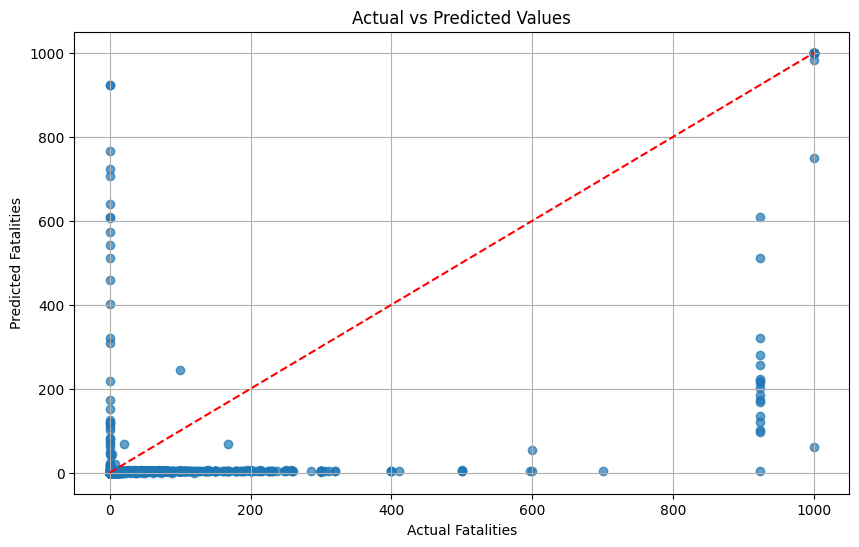

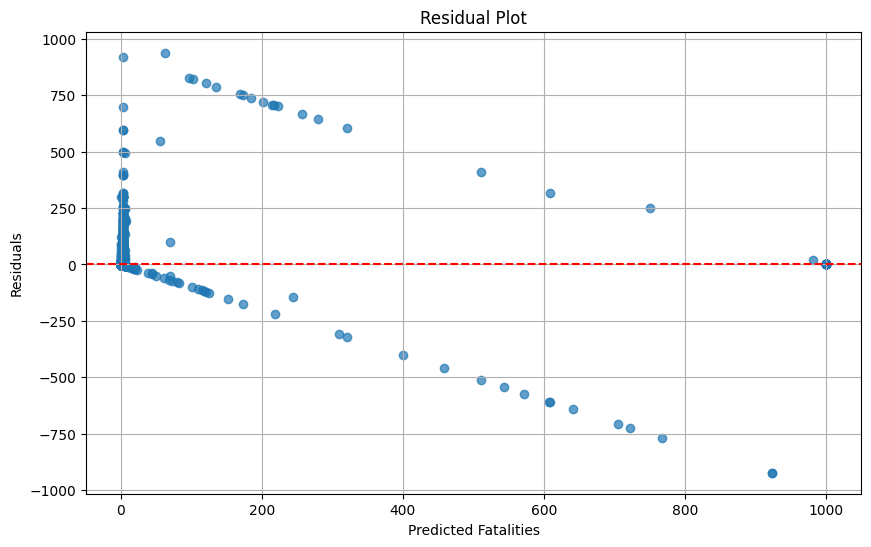

In [47]:
# Plot: Predicted vs Actual Values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Fatalities')
plt.ylabel('Predicted Fatalities')
plt.grid(True)
plt.show()

# Plot: Residuals
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Fatalities')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()